# Using ModelBuilder class for deploying PyMC models 
:::{post} Feb 22, 2023
:tags: deployment
:category: Advanced
:author: Shashank Kirtania, Thomas Wiecki
:::

## Motivation

Many users face difficulty in deploying their PyMC models to production because deploying/saving/loading a user-created model is not well standardized. One of the reasons behind this is there is no direct way to save or load a model in PyMC like scikit-learn or TensorFlow. The new `ModelBuilder` class is aimed to improve this workflow by providing a scikit-learn inspired API to wrap your PyMC models.

The new `ModelBuilder` class allows users to use methods to `fit()`, `predict()`, `save()`, `load()`. Users can create any model they want, inherit the `ModelBuilder` class, and use predefined methods.

Let's go through the full workflow, starting with a simple linear regression PyMC model as it's usually written. Of course, this model is just a place-holder for your own model.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from numpy.random import RandomState

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927

rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [2]:
# Generate data
x = np.linspace(start=0, stop=1, num=100)
y = 0.3 * x + 0.5 + rng.normal(0, 1, len(x))

## Standard syntax
Usually a PyMC model will have this form:

In [3]:
with pm.Model() as model:
    # priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    eps = pm.HalfNormal("eps", 1.0)

    # observed data
    y_model = pm.Normal("y_model", mu=a + b * x, sigma=eps, observed=y)

    # Fitting
    idata = pm.sample()
    idata.extend(pm.sample_prior_predictive())

    # posterior predict
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [a, b, eps, y_model]
Sampling: [y_model]


How would we deploy this model? Save the fitted model, load it on an instance, and predict? Not so simple.

`ModelBuilder` is built for this purpose. It is currently part of the  `pymc-experimental` package which we can pip install with `pip install pymc-experimental`. As the name implies, this feature is still experimental and subject to change.

## Model builder class

Let's import the `ModelBuilder` class.

In [4]:
from pymc_experimental.model_builder import ModelBuilder

To define our desired model we inherit from the `ModelBuilder` class. There are a couple of methods we need to define.

In [5]:
class LinearModel(ModelBuilder):
    # Give the model a name
    _model_type = "LinearModel"
    # And a version
    version = "0.1"

    def build_model(self, model_config, data=None):
        """
        build_model creates the PyMC model

        Parameters:
        model_config: dictionary
            it is a dictionary with all the parameters that we need in our model example:  a_loc, a_scale, b_loc
        data: Dict[str, Union[np.ndarray, pd.DataFrame, pd.Series]]
            Data we want our model fit on.
        """
        # Note that we do not have to define a with-context

        # Create mutable data containers
        x_data = pm.MutableData("x_data", data["input"].values)
        y_data = pm.MutableData("y_data", data["output"].values)

        # prior parameters
        a_mu_prior = model_config.get("a_mu_prior", 0.0)
        a_sigma_prior = model_config.get("a_sigma_prior", 1.0)
        b_mu_prior = model_config.get("b_mu_prior", 0.0)
        b_sigma_prior = model_config.get("b_sigma_prior", 1.0)
        eps_prior = model_config.get("eps_prior", 1.0)

        # priors
        a = pm.Normal("a", mu=a_mu_prior, sigma=a_sigma_prior)
        b = pm.Normal("b", mu=b_mu_prior, sigma=b_sigma_prior)
        eps = pm.HalfNormal("eps", eps_prior)

        obs = pm.Normal("y", mu=a + b * x_data, sigma=eps, shape=x_data.shape, observed=y_data)

    def _data_setter(self, data: pd.DataFrame):
        """
        _data_setter works as a set_data for the model and updates the data whenever we need to.
        Parameters:
        data: Dict[str, Union[np.ndarray, pd.DataFrame, pd.Series]]
            It is the data we need to update for the model.
        """

        with self.model:
            pm.set_data({"x_data": data["input"].values})
            if "output" in data.columns:
                pm.set_data({"y_data": data["output"].values})

    @classmethod
    def create_sample_input(cls):
        """
        Creates example input and parameters to test the model on.
        This is optional but useful.
        """

        x = np.linspace(start=0, stop=1, num=100)
        y = 0.3 * x + 0.5
        y = y + np.random.normal(0, 1, len(x))
        data = pd.DataFrame({"input": x, "output": y})

        model_config = {
            "a_mu_prior": 0.0,
            "a_sigma_prior": 1.0,
            "b_mu_prior": 0.0,
            "b_sigma_prior": 1.0,
            "eps_prior": 1.0,
        }

        sampler_config = {
            "draws": 1_000,
            "tune": 1_000,
            "chains": 3,
            "target_accept": 0.95,
        }

        return data, model_config, sampler_config

Now we can create the `LinearModel` object.

But we need some example data. This is where defining a `create_sample_input()` method as done above is useful. It gives users of your model an easy way to generate data (and configurations) to test your model on.

In [6]:
data, model_config, sampler_config = LinearModel.create_sample_input()
model = LinearModel(model_config, sampler_config, data)

After making the object of class `LinearModel` we can fit the model using the `.fit()` method.

## Fitting to data

The `fit()` method takes one argument `data` on which we need to fit the model. The meta-data is saved in the `InferenceData` object where also the trace is stored. These are the fields that are stored:

* `id` : This is a unique id given to a model based on model_config, sample_conifg, version, and model_type. Users can use it to check if the model matches to another model they have defined.
* `model_type` : Model type tells us what kind of model it is. This in this case it outputs **Linear Model** 
* `version` : In case you want to improve on models, you can keep track of model by their version. As the version changes the unique hash in the `id` also changes.
* `sample_conifg` : It stores values of the sampler configuration set by user for this particular model.
* `model_config` : It stores values of the model configuration set by user for this particular model.

In [7]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 7 seconds.
Sampling: [a, b, eps, y]
Sampling: [y]


/Users/twiecki/miniforge3/envs/pymc5/lib/python3.10/site-packages/arviz/data/inference_data.py:1427: UserWarning: The group fit_data is not defined in the InferenceData scheme
  warnings.warn(


## Saving model to file

After fitting the model, we can probably save it to share the model as a file so one can use it again.
To `save()` or `load()`, we can quickly call methods for respective tasks with the following syntax.

In [8]:
fname = "linear_model_v1.nc"
model.save(fname)

This saves a file at the given path, and the name <br>
A NetCDF `.nc` file that stores the inference data of the model.

## Loading a model

Now if we wanted to deploy this model, or just have other people use it to predict data, they need two things:
1. the `LinearModel` class (probably in a .py file)
2. the linear_model_v1.nc file

With these, you can easily load a fitted model in a different environment (e.g. production):

In [9]:
model_2 = LinearModel.load(fname)

/Users/twiecki/miniforge3/envs/pymc5/lib/python3.10/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


Note that `load()` is a class-method, we do not need to instantiate the `LinearModel` object.

In [10]:
type(model_2)

__main__.LinearModel

## Prediction

Next we might want to predict on new data. The `predict()` method allows users to do posterior prediction with the fitted model on new data.

Our first task is to create data on which we need to predict.

In [11]:
x_pred = np.random.uniform(low=1, high=2, size=10)
prediction_data = pd.DataFrame({"input": x_pred})

`ModelBuilder` provides two methods for prediction:
1. point estimates (the mean) with `predict()`
2. full posterior prediction (samples) with `predict_posterior()`

In [12]:
pred_mean = model_2.predict(prediction_data)
# samples
pred_samples = model_2.predict_posterior(prediction_data)

Sampling: [y]


Sampling: [y]


After using the `predict()`, we can plot our data and see graphically how satisfactory our `LinearModel` is.

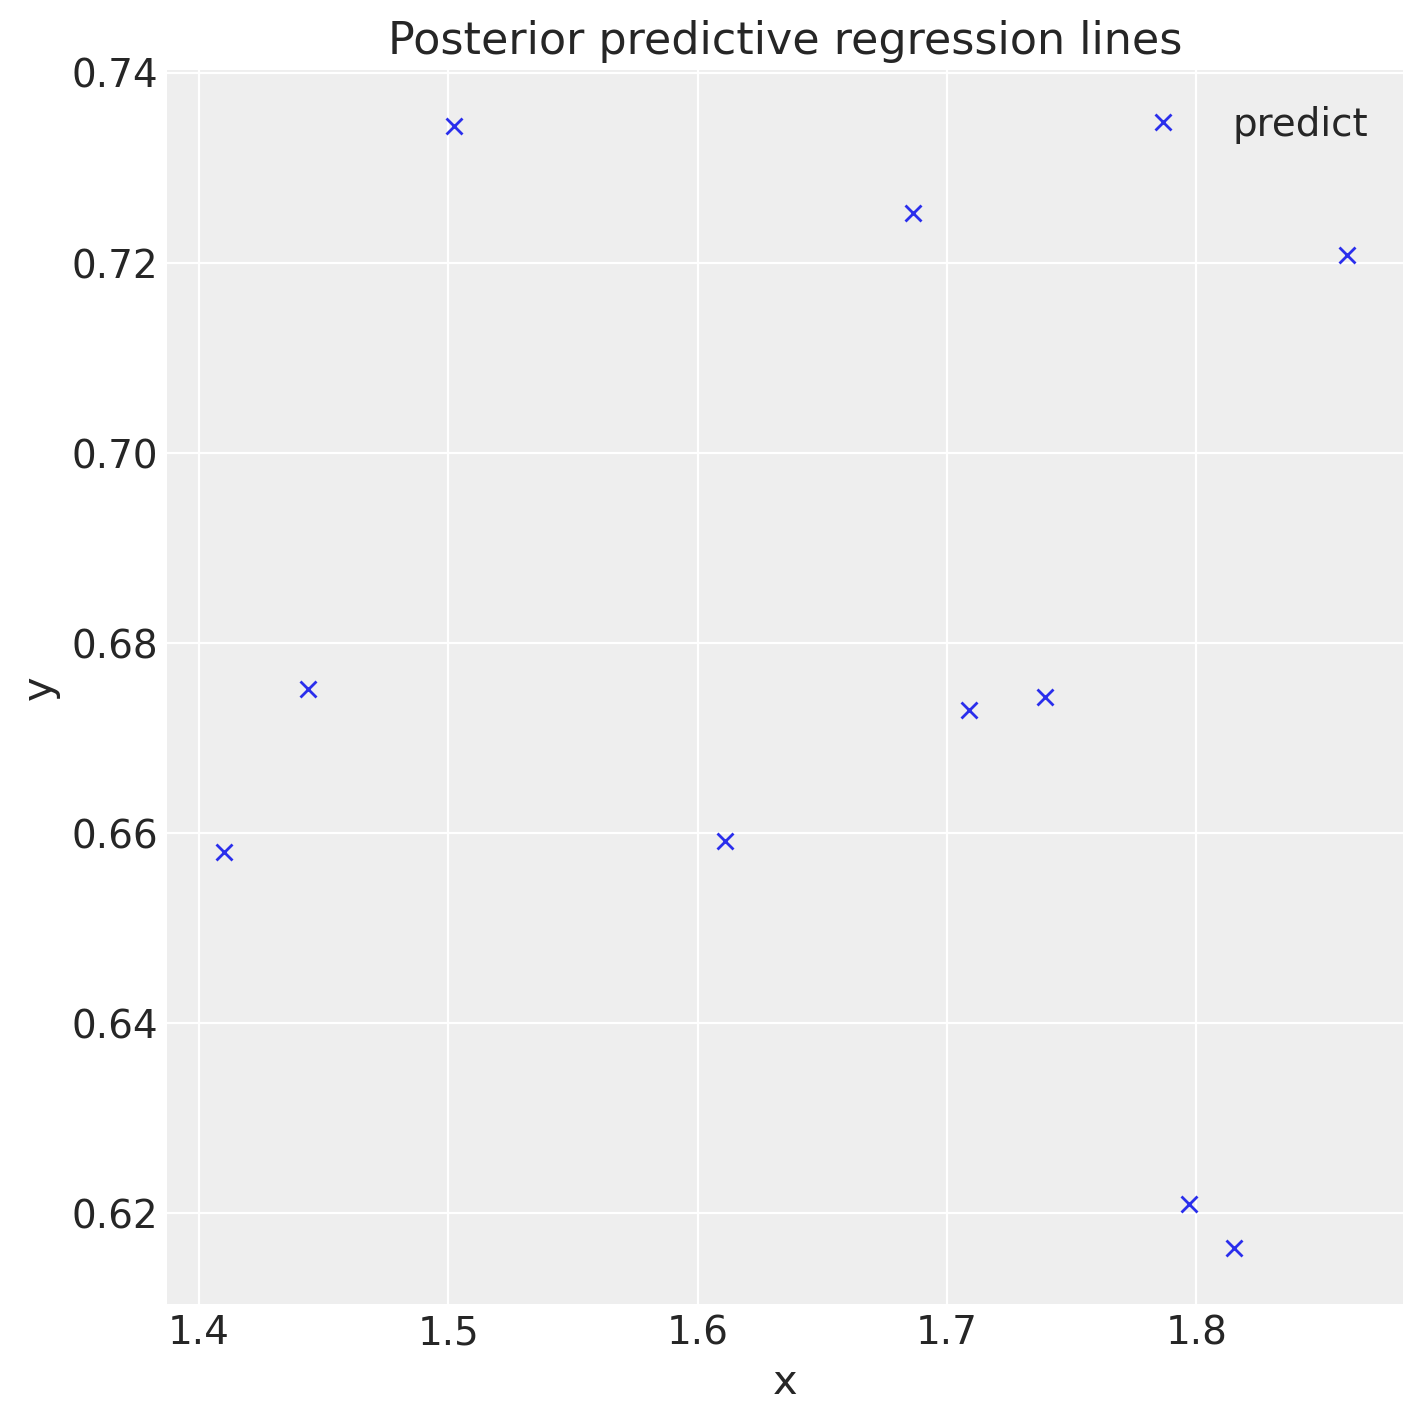

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(
    x_pred,
    pred_mean["y"],
    "x",
    label="predict",
)
ax.set(title="Posterior predictive regression lines", xlabel="x", ylabel="y")
plt.legend(loc=0);

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_experimental

Last updated: Wed Feb 22 2023

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

pymc_experimental: 0.0.2

matplotlib: 3.6.2
numpy     : 1.23.5
pandas    : 1.5.2
arviz     : 0.14.0
pymc      : 5.0.1

Watermark: 2.3.1



## Authors
* Authored by Shashank Kirtania and Thomas Wiecki in 2023.

:::{include} ../page_footer.md
:::